In [16]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tf2onnx
from PIL import Image
from sklearn.model_selection import train_test_split

### Dataset

In [17]:
# !wget -O dataset.zip https://chmura.put.poznan.pl/s/LxYSsota5PCbXcU/download
# !mkdir dataset_jetbot
# !unzip dataset.zip
# !rm dataset/1652875851.3497071/0199.jpg

In [18]:
def preprocess_image(img):
    img = cv2.resize(img, (64, 64))
    return np.array(img).astype(np.float32) / 255

In [19]:
def create_dataset(img_folder):
    X, y = [], []
    for dir1 in os.listdir(img_folder):
        if '.csv' not in dir1:
            csv = pd.read_csv(os.path.join(img_folder, dir1 + '.csv'), sep=',', header=None)
            for row in csv.iterrows():
                y.append((row[1][1], row[1][2]))
            for file in sorted(os.listdir(os.path.join(img_folder, dir1))):
                image = cv2.imread(os.path.join(img_folder, dir1, file), cv2.COLOR_BGR2RGB)
                X.append(preprocess_image(image))

    return np.array(X), np.array(y)

In [20]:
X, y = create_dataset('./dataset/')
X.shape, y.shape

((7584, 64, 64, 3), (7584, 2))

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=23)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5308, 64, 64, 3), (2276, 64, 64, 3), (5308, 2), (2276, 2))

### Model

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(64, 64, 3)),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='tanh')
])

In [23]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mae'])

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 128)       

In [25]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=7, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_mae", factor=0.1, patience=2, min_lr=0.0001)
history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/100
166/166 [==============================] - 9s 54ms/step - loss: 0.2825 - mae: 0.3862 - val_loss: 0.2248 - val_mae: 0.3008 - lr: 0.0100
Epoch 2/100
166/166 [==============================] - 9s 52ms/step - loss: 0.2496 - mae: 0.3435 - val_loss: 0.2163 - val_mae: 0.2919 - lr: 0.0100
Epoch 3/100
166/166 [==============================] - 9s 54ms/step - loss: 0.2360 - mae: 0.3298 - val_loss: 0.2089 - val_mae: 0.2860 - lr: 0.0100
Epoch 4/100
166/166 [==============================] - 9s 57ms/step - loss: 0.2250 - mae: 0.3177 - val_loss: 0.2011 - val_mae: 0.2834 - lr: 0.0100
Epoch 5/100
166/166 [==============================] - 9s 55ms/step - loss: 0.2152 - mae: 0.3102 - val_loss: 0.1928 - val_mae: 0.2846 - lr: 0.0100
Epoch 6/100
166/166 [==============================] - 9s 53ms/step - loss: 0.2036 - mae: 0.3055 - val_loss: 0.1802 - val_mae: 0.2822 - lr: 0.0100
Epoch 7/100
166/166 [==============================] - 9s 55ms/step - loss: 0.1879 - mae: 0.2976 - val_loss: 0.1607 - 

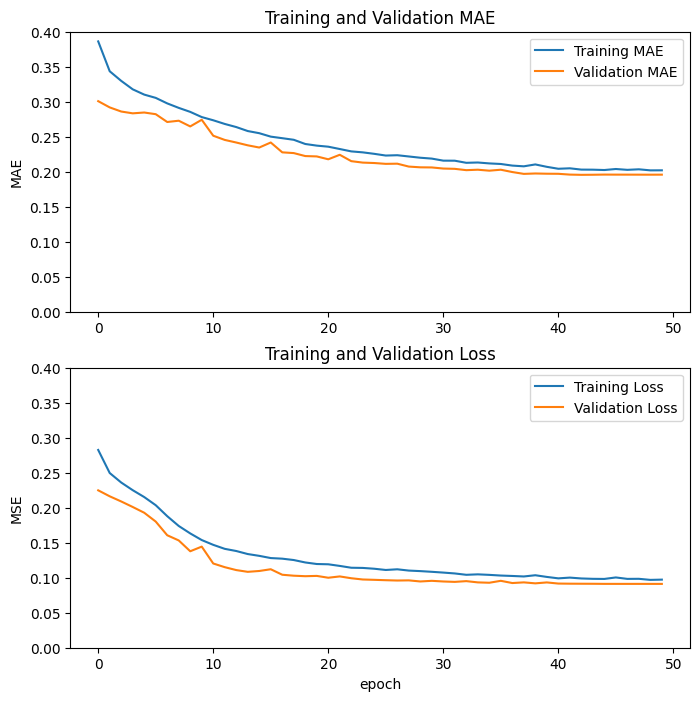

In [26]:
mae = history.history['mae']
val_mae = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.legend(loc='upper right')
plt.ylabel('MAE')
plt.ylim([0, 0.4])
plt.title('Training and Validation MAE')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('MSE')
plt.ylim([0, 0.4])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

1/1 [==============================] - 0s 67ms/step
[[0.8953342 0.7412031]]
[1.        0.9921875]


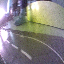

In [27]:
idx = 1000

print(model.predict(X_test[idx][np.newaxis, ...]))
print(y_test[idx])
Image.fromarray(np.asarray(X_test[idx] * 255).astype(np.uint8))

In [28]:
final_mae = model.evaluate(X_test, y_test)[1]

72/72 [==============================] - 1s 14ms/step - loss: 0.0914 - mae: 0.1956


In [29]:
model.save(f"./models/custom_model_no_aug_{final_mae:0.3f}")

INFO:tensorflow:Assets written to: ./models/custom_model_no_aug_0.196\assets


INFO:tensorflow:Assets written to: ./models/custom_model_no_aug_0.196\assets


In [30]:
spec = (tf.TensorSpec((None, 64, 64, 3), tf.float32, name="input"),)
model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=11,
                                            output_path=f"onnx/custom_model_no_aug_{final_mae:0.3f}.onnx")